# SAMPLE RUNTHROUGH

## PREPARE DATA

In [1]:
with open('data/names.txt') as f:
    names = f.readlines()
names = [name.strip() for name in names]

itos = {}
stoi = {}

itos[0]='.'
stoi['.']=0

letters=sorted(list(set("".join(names))))

for idx,letter in enumerate(letters):
    stoi[letter]=idx+1
    itos[idx+1]=letter

print(stoi)
print(itos)



{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [2]:
# Don't change these parameters, as they are used in the explanation in the SAMPLE RUNTHROUGH part
SAMPLE_CONTEXT_SIZE = 3
SAMPLE_LETTER_EMBEDDING_SIZE=2
SAMPLE_TRAINING_DATA_SIZE=5
SAMPLE_HIDDEN_LAYER_NEURONS=100

In [3]:
import torch

def generate_training_data(names,block_size=3,print_out=False):
    X = []
    Y = []
    for name in names:
        name = name + "."
        context = block_size * [0]
        if print_out:
            print(name)
        for ch in name:
            context_str = "".join([itos[idx] for idx in context])
            predict_str = ch
            if print_out:
                print(f"{context_str}-->{predict_str}")
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:]+[stoi[ch]]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X, Y

X,Y = generate_training_data(names[:SAMPLE_TRAINING_DATA_SIZE],SAMPLE_CONTEXT_SIZE)



We have 32 examples with 3 context letters each

In [4]:
X.shape

torch.Size([32, 3])

## START BUILDING THE NEURAL NETWORK

### ARCHITECTURE OF NEURAL NETWORK
![](./data/img/makemore_l2.png)

!ps in second layer ther is 6 rows and 100 cols

### CREATE LETTER EMBEDDINGS

Represent each letter in alpabeth with 2 dimensional embedding vector. Initialize the embedding vectors randomly.

In [5]:
C = torch.randn(27,SAMPLE_LETTER_EMBEDDING_SIZE).float()
C.shape

torch.Size([27, 2])

Create embeddings "emb" for all the training samples for each context word.       
The result: A tensor (multidimensional matrix) with dimensions | Train size * Context Size * Letter embedding Size |

Where 

- Train size : How many training examples our data has 
- Context size : How many previous letters we use to predict the next letter
- Letter embedding size : How many dimensions we use to model 1 letter

In [6]:
emb = C[X] 
# C is 27 * 2
# X is 32 * 3 where each value is a letter index from 0-27 
# We basically choose a 2 dimensional vector for each letter index in X
emb.shape

torch.Size([32, 3, 2])

Below is the first training sample context letters as 2 dimensional vectors

In [7]:
emb[0]

tensor([[-0.9071,  0.1926],
        [-0.9071,  0.1926],
        [-0.9071,  0.1926]])

### CREATE NEURON WEIGHTS

Each neuron has weight for all context letter all dimensions


In [8]:
W1 = torch.randn([SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE,SAMPLE_HIDDEN_LAYER_NEURONS])
W1.shape

torch.Size([6, 100])

Let's create bias parameter as well

In [9]:
b1 = torch.randn(SAMPLE_HIDDEN_LAYER_NEURONS) 
b1.shape

torch.Size([100])

### SHAPE TRAINING DATA SO WE COULD MATRIX MULTIPLY IT WITH NEURONS

This means the training data rows need to have have as many columns as neurons take inputs.

**NOT WELL PERFORMING SAMPLE**

The unbind operation seems to take a particular dimension and remove it in a way that instead of that dimension you will have that dimension represented in multiple lists for each dimension. It allows us to do easy concatenation.

In [10]:
training_data = torch.cat(torch.unbind(emb,1),1) 

In [11]:
training_data.shape

torch.Size([32, 6])

**BETTER PERFORMING SAMPLE** 

View is a much faster operation compared to cat and bind because it does not need to use extra memory. It is also able to sort of unstack the tensor dimensions

In [12]:
(torch.eq(training_data, emb.view(-1,6)).all())

tensor(True)

emb.view(-1,6)

### FIRST PART OF FORWARD PROPAGATION

Here we flow the data through first 100 neurons. 

For each sample we now get 100 values. 


In [13]:
training_data = emb.view(-1,SAMPLE_CONTEXT_SIZE*SAMPLE_LETTER_EMBEDDING_SIZE) 
h = training_data @ W1 + b1
h.shape

torch.Size([32, 100])

### COMPLETE ONE TIME FORWARD PASS

We create second layer with softmax function. There will be 27 neurons,
each neuron output will be a probability for particular letter

In [14]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
logits = h.tanh() @ W2 + b2 
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)


Check that for each training sample the probabilities will equal = 1

In [15]:
probs.sum(1,keepdim=True)[:10]

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

For each X get the probability for the right prediction. If it is low, the loglikelihood will return high loss

In [16]:
loss  = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [17]:
loss

tensor(14.3764)

## QUESTIONS


### QUESTION 1

- Are dimension mapping for each particular letter parameters in this neural network? 


### QUESTION 2

- If our dataset has 200 training examples. Each letter is mapped to 2 dimensions. We will have 100 neurons in middle layer and 27 neurons in the output layer. How many times for we update gradient for 1 character 1 dimension ?

## ANSWERS 


### ANSWER 1

- Yes, these are All dimensions for the 27 letters . These we will update in each training run to reduce loss. These parameters affect the multiplication with each neuron in the first hidden layer. 

### ANSWER 2 

Letter Dimension for one of the 27 layers is an instance shared among multiple training sample pairs. The cost function is calculated as comparison between all the training sample pairs. So if if specific word occurs in a training sample pair, then it's dimensions will also occur in the training sample pair which means it there is going to be a gradient update. 
In addition, the letter dimension will be input to 100 neurons. So for each neuron there willl be also gradient update based on that training sample pair. .    
- In total, anwswer is going to be TRAINING_SET_OCCURENCES * OUTPUT_NEURONS_FOR_LETTER_EMBEDDINGS which in this case is 200 * 100  . More info on my [YT explanation](https://www.youtube.com/watch?v=KUw20-24YNE&ab_channel=AndresNamm)

# MORE RESPECTABLE VERSION OF NEURAL NETWORK + TRAINING

Lets define some default hyperparameters

In [18]:
EMBEDDING_DIMENSION = 2
CONTEXT_SIZE = 3
TRAINING_SIZE = -1 # -1 means all data
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 30

Let us now generate new training data

In [19]:
X,Y = generate_training_data(names[:TRAINING_SIZE], block_size=CONTEXT_SIZE,print_out=False)

print(f"X shape {X.shape}")
print(f"Y shape {Y.shape}")

X shape torch.Size([228140, 3])
Y shape torch.Size([228140])


Initialize parameters

In [20]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,EMBEDDING_DIMENSION,generator=g) 
W1 = torch.randn(EMBEDDING_DIMENSION*CONTEXT_SIZE,HIDDEN_LAYER_SIZE,generator=g)
B1 = torch.randn(HIDDEN_LAYER_SIZE,generator=g) # Add to every neuron bias
W2 = torch.randn(HIDDEN_LAYER_SIZE,27,generator=g)
B2 = torch.randn(27) # Add to every neuron bias

params = [C,W1,B1,W2,B2]
param_count = sum([p.nelement()  for p in params])
print(f"Total parameters currently in NN {param_count}")

for p in params:
    p.requires_grad=True




Total parameters currently in NN 3481


## TRAINING WITH FULL DATA

In [21]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation
    h = (C[X].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    # manual method
    # counts = logits.exp()
    # probs = counts/counts.sum(1,keepdim=True)
    # loss += -probs[torch.arange(len(X)),Y].log().mean()
    loss = F.cross_entropy(logits, Y)

    print(f"Total loss currently is {loss}")
    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1#type:ignore

    if i > 3:
        print("This is too slow, let's implement the minibatch approach")
        break


Total loss currently is 19.25423812866211
Total loss currently is 16.593082427978516
Total loss currently is 15.426432609558105
Total loss currently is 14.480133056640625
Total loss currently is 13.65930461883545
This is too slow, let's implement the minibatch approach


## TRAINING WITH MINIBATCHES

In [22]:
import torch.nn.functional as F

for i in range(100):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 10 == 0:
        print(f"Iteration {i}: Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * 0.1 #type: ignore



Iteration 0: Total loss currently is 11.653096199035645
Iteration 10: Total loss currently is 10.032585144042969
Iteration 20: Total loss currently is 7.826599597930908
Iteration 30: Total loss currently is 6.8802313804626465
Iteration 40: Total loss currently is 4.442126750946045
Iteration 50: Total loss currently is 5.986899375915527
Iteration 60: Total loss currently is 3.899444580078125
Iteration 70: Total loss currently is 5.957088947296143
Iteration 80: Total loss currently is 3.8105015754699707
Iteration 90: Total loss currently is 5.225488185882568


## TRYING TO FIND THE BEST LEARNING RATE

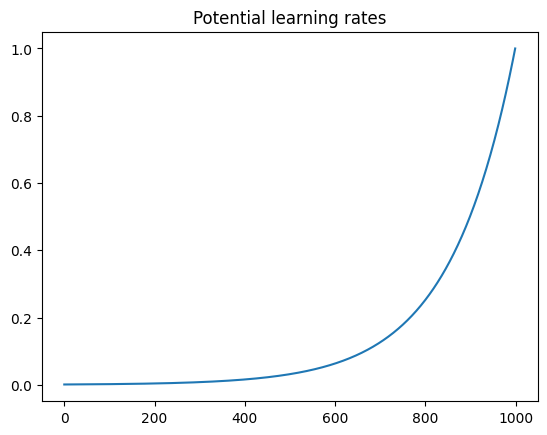

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

lre = torch.linspace(-3,-0,1000)
lr = 10 ** lre
plt.title("Potential learning rates")
plt.plot(lr)

In [24]:
lri = []
lossi = []

for i in range(1000):
    # Forward propagation

    minibatch = torch.randint(0,X.shape[0],(31,))
    h = (C[X[minibatch]].view(-1,EMBEDDING_DIMENSION*CONTEXT_SIZE)  @ W1 + B1).tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y[minibatch])

    if i % 100==0:
        print(f"Total loss currently is {loss}")

    for param in params:
        param.grad=None

    loss.backward()

    for param in params: 
        param.data -= param.grad * lr[i]

    lri.append(lr[i])
    lossi.append(loss.item())


Total loss currently is 3.862201452255249
Total loss currently is 3.891622304916382
Total loss currently is 2.9183509349823
Total loss currently is 3.5592617988586426
Total loss currently is 2.8774631023406982
Total loss currently is 3.4502880573272705
Total loss currently is 2.8123531341552734
Total loss currently is 3.2618906497955322
Total loss currently is 3.775346040725708
Total loss currently is 4.6444993019104


We choose the learning rate from area where we see the loss is generally low. 
This method might not be mathematically super provable but visually here we actually find area where loss in general is low and gives us good estimation

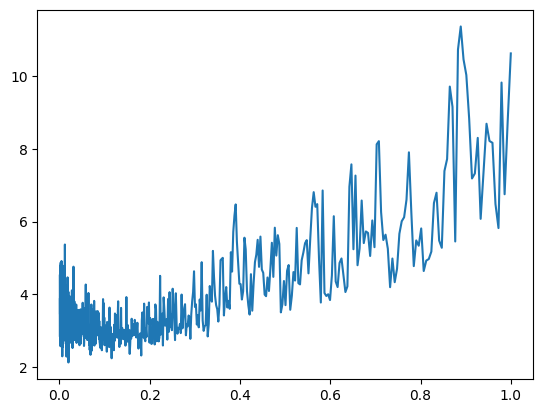

In [25]:
plt.plot(lri,lossi)

# FURTHER TUNING TRAINING TO GET LOWEST LOSS POSSIBLE SCORE

In [26]:
import sys

print(sys.path)

['/home/njx4489/repod/nn_zero_to_hero', '/home/njx4489/.pyenv/versions/3.11.5/lib/python311.zip', '/home/njx4489/.pyenv/versions/3.11.5/lib/python3.11', '/home/njx4489/.pyenv/versions/3.11.5/lib/python3.11/lib-dynload', '', '/home/njx4489/repod/nn_zero_to_hero/.venv/lib/python3.11/site-packages']


## MAKE THE TRAINING EVEN MORE PROPER

In [27]:
from makemore.prepare_data import generate_training_data
from makemore.neural_network import NeuralNetwork, TrainingParams

def train_neural_network(names, context_size, letter_embedding_size, hidden_layer_neurons, batch_size, lr, epochs):
    X,Y = generate_training_data(names, context_size)
    nn = NeuralNetwork(context_size,  hidden_layer_neurons)
    tp = TrainingParams(batch_size, lr, epochs)
    nn.train(X,Y,tp)
    return nn

In [28]:
from makemore.prepare_data import generate_training_data
from makemore.neural_network import NeuralNetwork, TrainingParams

def train_neural_network(context_size,hidden_layer_size,embedding_dimension,batch_size,epochs,learning_rate_func, print_flag=False):
    X,Y = generate_training_data(context_size,False)
    nn = NeuralNetwork(context_size=context_size,hidden_layer_neurons=hidden_layer_size,letter_embedding_dimensions=embedding_dimension,print_flag=print_flag)
    training_params = TrainingParams(batch_size=batch_size,iterations=epochs,learning_rate=learning_rate_func)
    nn.train(X,Y,training_params)
    return nn

In [43]:
epochs=1000
neural_nets = []
embedding_dimension=3

for context_size in [3,4,5]:
    print(f"Training with context size {context_size}")
    nn = train_neural_network(context_size=context_size,hidden_layer_size=100,embedding_dimension=embedding_dimension,batch_size=30,epochs=epochs,learning_rate_func=lambda i: [0.1,0.01,0.001][i//450],print_flag=True)
    neural_nets.append(nn)
    print(f"Neural network {nn.name} final loss: {nn.losses[-1]}")

Training with context size 3


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([9, 100])
Shape of b1: torch.Size([100])
Shape of w2: torch.Size([100, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 3808
Start training
NN_3_100_3 loss:after 1000 epochs: 2.8550355434417725
Neural network NN_3_100_3 final loss: 2.8550355434417725
Training with context size 4
Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 100])
Shape of b1: torch.Size([100])
Shape of w2: torch.Size([100, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 4108
Start training
NN_4_100_3 loss:after 1000 epochs: 2.6773080825805664
Neural network NN_4_100_3 final loss: 2.6773080825805664
Training with context size 5
Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([15, 100])
Shape of b1: torch.Size([100])
Shape of w2: torch.Size([100, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 4408
Start training
NN_5_100_3 loss:after 1000 epochs: 2.769273519515991
Neural network NN_5_

Context size 5 had the lowest loss

In [44]:
for hidden_layer_size in [100,150,200]:
    nn = train_neural_network(context_size=5,hidden_layer_size=hidden_layer_size,embedding_dimension=embedding_dimension,batch_size=30,epochs=epochs,learning_rate_func=lambda i: [0.1,0.01,0.001][i//450],print_flag=True)


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([15, 100])
Shape of b1: torch.Size([100])
Shape of w2: torch.Size([100, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 4408
Start training
NN_5_100_3 loss:after 1000 epochs: 2.7565884590148926
Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([15, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6558
Start training
NN_5_150_3 loss:after 1000 epochs: 2.8459906578063965
Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([15, 200])
Shape of b1: torch.Size([200])
Shape of w2: torch.Size([200, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 8708
Start training
NN_5_200_3 loss:after 1000 epochs: 3.0493693351745605


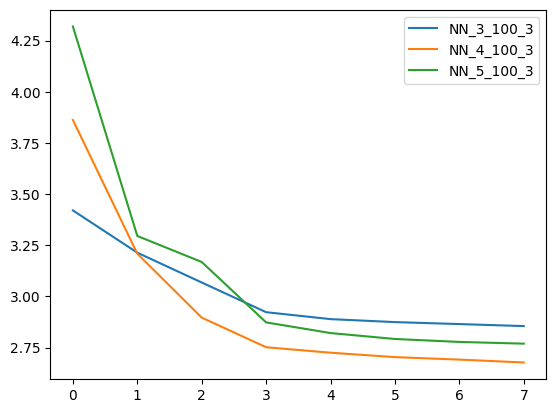

In [46]:
import matplotlib.pyplot as plt
from math import log10




for nn in neural_nets:
    plt.plot([(loss.item()) for loss in nn.losses[-8:]], label=nn.name, scaley=True )

# Add a legend
plt.legend()

# Show the plot
plt.show()

From this chart and final improvements it seems 

## MANUAL FINE TUNING WITH SMALL LEARNING RATE

# TRAIN/DEV/TEST SET

In [32]:
import random
random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

Xtr,Ytr = generate_training_data(names[:n1])
Xdv,Ydv = generate_training_data(names[n1:n2])
Xts,Yts = generate_training_data(names[n2:])
